<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/classical_shadows_qiskit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [1]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install numpy
!pip install matplotlib
!pip install pylatexenc
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 8.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━

In [2]:
import qiskit
import qiskit_ibm_runtime
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, DensityMatrix
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator, Batch

from qiskit_aer import AerSimulator
from qiskit.circuit import ParameterVector

from functools import cache

# Utility Functions

In [3]:
def generate_pauli_string(location, pauli, num_qubits):
    string = ["I"] * num_qubits
    for i, loc in enumerate(location):
        string[num_qubits-loc-1] = pauli[i]

    result = ''.join(char for char in string)

    return result

In [4]:
def Minv(N,X):
    '''inverse shadow channel'''
    return ((2**N+1.))*X - np.eye(2**N)

def twototen(n):
  sum = 0
  for i in range(num_qubits):
    sum = sum + (int(n[i]))*(2**i)
  return sum

In [5]:
def derandomization(observables, shadow_num, accuracy, num_qubits):
    p_sharp = np.empty((num_qubits, shadow_num),dtype=str)
    nu =  1-np.exp(-0.5*accuracy**2)
    pauli_list = ["X", "Y", "Z"]
    f_list =  []

    obs_strings = []


    for obs in observables:
        obs_strings.append(obs.to_list()[0][0])

    def check_prod(obs_string, p_sharp, n,m):
        for l in range(n):
            if not (obs_string[num_qubits-1-l] == "I" or obs_string[num_qubits-1-l] == p_sharp[l][m]):
                return 0
        return 1

    def w(o):
        sum = 0
        for c in o:
               if c != "I":
                    sum +=1
        return sum
    def conditional_exp_val(obs_strings, pauli,k,m):
        sum = 0
        for l, obs in enumerate(obs_strings):
            expval = 0
            expval += check_prod(obs, p_sharp, num_qubits, m)
            expval = -0.5 * accuracy**2 * expval
            if obs[num_qubits-1-k] == "I" or obs[num_qubits-1-k] == pauli:
                prod_1 = 1-nu/(3**(w(obs[0:num_qubits-k-1])))*check_prod(obs, p_sharp, k-1, m)
            else:
                prod_1 = 1
            prod_2  = (1-nu*3**(-w(obs)))**(shadow_num-m)
        sum += np.exp(expval) * prod_1 * prod_2
        return sum


    for m in range(shadow_num):
        for k in range(num_qubits):
            for W in pauli_list:
                f = conditional_exp_val(obs_strings, W, k, m)
                f_list.append(f)

            min_index = f_list.index(min(f_list))
            if min_index == 0:
                final_pauli = "X"
            elif min_index == 1:
                final_pauli = "Y"
            else:
                final_pauli = "Z"
            p_sharp[k][m] = final_pauli


    p_sharp = p_sharp.T

    final_observables = []

    for m in range(shadow_num):
        string = ''.join(str(e) for e in p_sharp[m])
        string = string[::-1]
        observable = SparsePauliOp(string)
        final_observables.append(observable)


    return final_observables

# Backend Management

In [6]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-skku/hackathon-2024/hackathon',
    token='24ce54238a7bb29fe5e3eb450acefed2444169ce5e525f08f9515676b1cf257ea65b85895d4157a30359eb3d9a4aab9873008d7edf6ff177ed29015e625e4ad6'
)
real_backend = service.least_busy(operational=True, simulator=False)

In [7]:
from qiskit_aer import AerSimulator
simulator =  AerSimulator()

# Obtain Snapshots

In [8]:
def snapshots(qc, size, backend = None, gate_set="clifford", derand = False, accuracy=0.1,K=10):
  # qc: Generate rho circuit
  # size: shadow size
  # backend: Backend
  # gate_set: Clifford or Pauli gate set, derandomization requires Pauli
  # accuracy: Accuracy parameter for derandomization
  # k: Number of clusters
  num_qubits = qc.num_qubits
  gateset = []

  if gate_set == "clifford":
    gateset = [qiskit.quantum_info.random_clifford(num_qubits) for _ in range(size)]
  elif gate_set == "pauli":
    gateset = [SparsePauliOp(generate_pauli_string(range(num_qubits), [np.random.choice(["X","Y","Z"]) for _ in range(num_qubits)], num_qubits)) for _ in range(size)]
    if derandomization:
      gateset = derandomization(gateset,size, accuracy, num_qubits)

  results = []
  for idx, gate in enumerate(gateset):
    if gate_set == "clifford":
      qc_c  = qc.compose(gate.to_circuit())
    elif gate_set == "pauli":
      qc_c = qc
      qc_c.pauli(gate.to_list()[0][0],qubits= range(num_qubits))
    if backend is None:
      counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(1)
    else:
      qc_c.measure_all()
      sampler = Sampler(backend)
      pm = generate_preset_pass_manager(backend=simulator, optimization_level=1)
      isa_circuit = pm.run(qc_c)
      job = sampler.run([(isa_circuit)],shots=1)
      print("Job Run:" + "" + str(idx))
      result = job.result()[0]
      counts = result.data.meas.get_counts()
    results.append(counts)

  shadows = []
  for gate, res in zip(gateset, results):
    mat = gate.adjoint().to_matrix()
    for bit,count in res.items():
        Ub = mat[:,int(bit,2)] # this is Udag|b>
        shadows.append(Minv(num_qubits,np.outer(Ub,Ub.conj()))*count)

  clustered_shadows = []


  for k in range(K):
    temp_matrix = shadows[(k-1)*int(size//K)]
    for l in range((k-1)*int(size//K)+1, k*int(size//K),1):
      temp_matrix += shadows[l]
    temp_matrix = temp_matrix * 1/(int(size//K))
    clustered_shadows.append(temp_matrix)



  return clustered_shadows

In [9]:
def observable_prediction(snapshots, observables):
    estimates = []
    for obs in observables:
        temp = [np.trace(np.matmul(obs, snapshot)) for snapshot in snapshots]
        estimates.append(np.median(temp))
    return estimates


In [10]:
def classical_shadow_estimation(observables,qc, size, backend= None, gate_set = "clifford", derand = False, accuracy = 0.1, k =10):
    clusters = snapshots(qc, size, backend, gate_set, derandomization,accuracy,k)
    estimates = observable_prediction(clusters,observables)
    return estimates

# Ideal output

In [11]:
def ideal_output(observables, qc):
    rho = DensityMatrix(qc)
    estimates = []
    for obs in observables:
        estimates.append(np.trace(np.matmul(rho, obs)))
    return estimates

# Circuit Sampling Tomography

In [12]:
def circuit_sampling(observables, qc, backend=None):
    num_qubits = qc.num_qubits
    if backend is None:
        backend = AerSimulator()
        isa_circuit = qc
        isa_observables=  observables
    else:
        pm = generate_preset_pass_manager(backend, optimization_level=1)
        isa_circuit = pm.run(qc)
        isa_observables = [obs.apply_layout(isa_circuit) for obs in observables]

    estimator = Estimator(backend)
    estimates = []
    for obs in observables:
        pub = [(isa_circuit,obs)]
        job = estimator.run(pub)
        print("Job Done:" + " " + str(obs))
        result = job.result()[0]
        estimates.append(result.data.evs)
        job.status()

    return estimates



# Define Rho Circuit (5Q)

In [13]:
def rho_circuit(params, num_qubits):

  ansatz = QuantumCircuit(num_qubits)
  it = iter(params)
  ansatz.h(range(0,5))

  ansatz.barrier()

  ansatz.cx(0, 1)
  ansatz.cx(2, 3)
  ansatz.rz(next(it), 1)
  ansatz.rz(next(it), 3)
  ansatz.cx(0, 1)
  ansatz.cx(2, 3)
  ansatz.cx(1, 2)
  ansatz.cx(3, 4)
  ansatz.rz(next(it), 2)
  ansatz.rz(next(it), 4)
  ansatz.cx(1, 2)
  ansatz.cx(3, 4)

  ansatz.barrier()

  ansatz.rx(next(it), 0)
  ansatz.rx(next(it), 1)
  ansatz.rx(next(it), 2)
  ansatz.rx(next(it), 3)
  ansatz.rx(next(it), 4)

  return ansatz

In [14]:
np.random.seed(666)
num_qubits = 5
params = np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00])

In [15]:
qc = rho_circuit(params, num_qubits)

In [16]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

In [17]:
hamiltonian

SparsePauliOp(['ZZIII', 'IZZII', 'IIZZI', 'IIIZZ', 'XIIII', 'IXIII', 'IIXII', 'IIIXI', 'IIIIX'],
              coeffs=[ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j,
 -1.+0.j])

In [18]:
hamiltonian = hamiltonian.to_matrix()

In [19]:
exact_values = ideal_output([hamiltonian],qc)

In [20]:
exact_values

[(-5.897228393301033-6.245004513516506e-17j)]

In [21]:
shots = 200

estimates = np.real(classical_shadow_estimation([hamiltonian], qc, shots, None, gate_set="pauli", derand=False, k=200))
print(estimates)

[-66.]


In [25]:
shots = 400

estimates = np.real(classical_shadow_estimation([hamiltonian], qc, shots, None, gate_set="pauli", derand=False, k=200))
print(estimates)

[-66.]


In [22]:
shots = 600

estimates = np.real(classical_shadow_estimation([hamiltonian], qc, shots, None, gate_set="pauli", derand=False, k=200))
print(estimates)

[-22.]


In [26]:
shots = 800

estimates = np.real(classical_shadow_estimation([hamiltonian], qc, shots, None, gate_set="pauli", derand=False, k=200))
print(estimates)

[-49.5]


In [23]:
shots = 1000

estimates = np.real(classical_shadow_estimation([hamiltonian], qc, shots, None, gate_set="pauli", derand=False, k=200))
print(estimates)

[-52.8]


In [24]:
shots = 200

estimates = np.real(classical_shadow_estimation([hamiltonian], qc, shots, None, gate_set="pauli", derand=True, k=200))
print(estimates)

[0.]


In [27]:
shots = 400

estimates = np.real(classical_shadow_estimation([hamiltonian], qc, shots, None, gate_set="pauli", derand=True, k=200))
print(estimates)

[-33.]


In [28]:
shots = 600

estimates = np.real(classical_shadow_estimation([hamiltonian], qc, shots, None, gate_set="pauli", derand=True, k=200))
print(estimates)

[-22.]


In [29]:
shots = 800

estimates = np.real(classical_shadow_estimation([hamiltonian], qc, shots, None, gate_set="pauli", derand=True, k=200))
print(estimates)

[-49.5]


In [30]:
shots = 1000

estimates = np.real(classical_shadow_estimation([hamiltonian], qc, shots, None, gate_set="pauli", derand=True, k=200))
print(estimates)

[-26.4]


# 4. Classical Shadow (Randomized Clifford Gates) 5Q

In [31]:
import qiskit
import qiskit_ibm_runtime
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator, Batch

from qiskit_aer import AerSimulator
from qiskit.circuit import ParameterVector

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library.standard_gates import IGate, XGate, YGate, ZGate

## ansatz and classical shadow

In [32]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(10)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX", "YIIII", "IYIII", "IIYII", "IIIYI", "IIIIY"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

In [33]:
# Ansatz for VQE

def circuit_base(params, num_qubits):

  ansatz = QuantumCircuit(num_qubits)
  it = iter(params)
  ansatz.h(range(0,5))

  ansatz.barrier()

  ansatz.cx(0, 1)
  ansatz.cx(2, 3)
  ansatz.rz(next(it), 1)
  ansatz.rz(next(it), 3)
  ansatz.cx(0, 1)
  ansatz.cx(2, 3)
  ansatz.cx(1, 2)
  ansatz.cx(3, 4)
  ansatz.rz(next(it), 2)
  ansatz.rz(next(it), 4)
  ansatz.cx(1, 2)
  ansatz.cx(3, 4)

  ansatz.barrier()

  ansatz.rx(next(it), 0)
  ansatz.rx(next(it), 1)
  ansatz.rx(next(it), 2)
  ansatz.rx(next(it), 3)
  ansatz.rx(next(it), 4)

  return ansatz

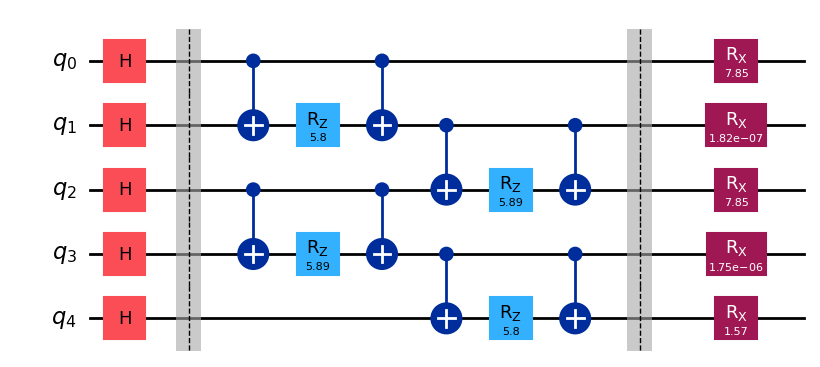

In [34]:
%matplotlib inline
num_qubits = 5
params = np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00])
qc = circuit_base(params, num_qubits)
qc.draw("mpl")

In [35]:
pauli_list = [
    np.array([[0.0, 1.0], [1.0, 0.0]]),
    np.array([[0, -1.0j], [1.0j, 0.0]]),
    np.array([[1.0, 0.0], [0.0, -1.0]]),
]

In [36]:
def Minv(N,X):
    '''inverse shadow channel'''
    return ((2**N+1.))*X - np.eye(2**N)

In [37]:
def cluster_rho(num_qubits, qc, size):

  reps = 1

  Cluster_Size = size
  cliffords = [qiskit.quantum_info.random_clifford(num_qubits) for _ in range(Cluster_Size)]

  results = []
  for cliff in cliffords:
    qc_c  = qc.compose(cliff.to_circuit())

    counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(1)
    results.append(counts)

  shadows = []
  for cliff, res in zip(cliffords, results):
    mat = cliff.adjoint().to_matrix()
    for bit,count in res.items():
        Ub = mat[:,int(bit,2)] # this is Udag|b>
        shadows.append(Minv(num_qubits,np.outer(Ub,Ub.conj()))*count)

  return np.sum(shadows,axis=0)/(Cluster_Size)

In [38]:
def generate_pauli_string(location, pauli, num_qubits):
    string = ["I"] * num_qubits
    for i, loc in enumerate(location):
        string[num_qubits-loc-1] = pauli[i]

    result = ''.join(char for char in string)

    return result

In [39]:
list_of_observables = ([SparsePauliOp(generate_pauli_string([i,i+1],["Z","Z"], num_qubits)) for i in range(num_qubits - 1)]  + [SparsePauliOp(generate_pauli_string([i],["X"], num_qubits)) for i in range(num_qubits)] + [SparsePauliOp(generate_pauli_string([i],["Y"], num_qubits)) for i in range(num_qubits)])

In [40]:
def clustor_observable(num_qubits, qc, size, list_of_observables):
  lst = []
  for o in list_of_observables:
    rho = cluster_rho(num_qubits, qc, size)
    o_matrix = o.to_matrix()
    lst.append(np.real(np.trace(np.matmul(rho, o_matrix))))

  lst = np.array(lst)

  return lst

In [41]:
def mean_hamiltonian(num_qubits, params, list_of_observables, shadow_size, size=200):
  qc = circuit_base(params, num_qubits)
  median_list = []

  sum = 0

  observable_list = []
  for i in range(shadow_size//200):
    observable_list.append(clustor_observable(num_qubits, qc, 200, list_of_observables))

  for j in range(9):
    med = np.median(np.array([observable_list[i][j] for i in range(shadow_size//200)]))

    if j<4:
      sum = sum + med

    else:
      sum = sum - med

  return sum

## cost function

In [42]:
def cost_func_clifford_shadow(params, shadow_size):
  num_qubits = 5
  list_of_observables = ([SparsePauliOp(generate_pauli_string([i,i+1],["Z","Z"], num_qubits)) for i in range(num_qubits - 1)]  + [SparsePauliOp(generate_pauli_string([i],["X"], num_qubits)) for i in range(num_qubits)] + [SparsePauliOp(generate_pauli_string([i],["Y"], num_qubits)) for i in range(num_qubits)])
  return mean_hamiltonian(num_qubits, params, list_of_observables, shadow_size, 200)

In [ ]:
shots = 200

lst = []
for _ in range(10):
  lst.append(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), shots))

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))

-5.972999999999993
1.1137194440252878


In [43]:
shots = 400

lst = []
for _ in range(10):
  lst.append(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), shots))

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))

KeyboardInterrupt: 

In [ ]:
shots = 600

lst = []
for _ in range(10):
  lst.append(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), shots))

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))

In [ ]:
shots = 800

lst = []
for _ in range(10):
  lst.append(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), shots))

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))

In [ ]:
shots = 1000

lst = []
for _ in range(10):
  lst.append(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), shots))

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))

In [ ]:
shots = 2000

lst = []
for _ in range(10):
  lst.append(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), shots))

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))

In [ ]:
shots = 5000

lst = []
for _ in range(10):
  lst.append(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), shots))

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))